In [3]:
import os
import numpy as np

import tensorflow as tf

from tensorflow.python.keras import backend as K

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from deepcell.applications import CytoplasmSegmentation
from deepcell.datasets.cytoplasm import hela_s3

from deepcell_toolbox import utils
from deepcell_toolbox.utils import resize, tile_image, untile_image_deprecated, untile_image

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [40]:
# new untile code
def _spline_window(window_size, stride_fraction=0.5, power=2, half=0):
        import scipy.signal
        """
        Squared spline (power=2) window function:
        https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
        """        
        reduced_window_size = int(window_size * 2* (1 - stride_fraction))
        intersection = int(reduced_window_size/4)
        wind_outer = (abs(2*(scipy.signal.triang(reduced_window_size))) ** power)/2
        wind_outer[intersection:-intersection] = 0        
        wind_inner = 1 - (abs(2*(scipy.signal.triang(reduced_window_size) - 1)) ** power)/2
        wind_inner[:intersection] = 0
        wind_inner[-intersection:] = 0        
        wind = wind_inner + wind_outer
        wind = wind / np.amax(wind)        
        
        new_wind = np.zeros((window_size,))
        new_wind[0:reduced_window_size // 2] = wind[0:reduced_window_size // 2]
        new_wind[-reduced_window_size // 2:] = wind[-reduced_window_size // 2:]
        new_wind[reduced_window_size // 2:-reduced_window_size // 2] = 1        

        if half == 0:
            return new_wind
        elif half == -1:
            new_wind[0:window_size // 2] = 1
        elif half == 1:
            new_wind[window_size // 2:] = 1
        return new_wind    

def _window_2D(window_size, stride_fraction=0.5, power=2, edge_0=None, edge_1=None):
        """
        Make a 1D window function, then infer and return a 2D window function.
        Done with an augmentation, and self multiplication with its transpose.
        Could be generalized to more dimensions.
        """
        if edge_0 is None:
            half_0 = 0
        elif edge_0 == -1:
            half_0 = -1
        elif edge_0 == 1:
            half_0 = 1    
        wind_0 = _spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_0)        
        if edge_1 is None:
            half_1 = 0
        elif edge_1 == -1:
            half_1 = -1
        elif edge_1 == 1:
            half_1 = 1    
        wind_1 = _spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_1)        
        wind_0 = np.expand_dims(np.expand_dims(wind_0, -1), -1)
        wind_1 = np.expand_dims(np.expand_dims(wind_1, -1), -1)        
        wind = wind_0 * wind_1.transpose(1, 0, 2)
        return wind    

def _untile_image(tiles, tiles_info, model_input_shape=(512, 512), stride_fraction=0.5):
        _axis = 1
        image_shape = tiles_info['image_shape']
        batches = tiles_info['batches']
        x_starts = tiles_info['x_starts']
        x_ends = tiles_info['x_ends']
        y_starts = tiles_info['y_starts']
        y_ends = tiles_info['y_ends']
        stride_x = tiles_info['stride_x']
        stride_y = tiles_info['stride_y']        
        tile_size_x = model_input_shape[0]
        tile_size_y = model_input_shape[1]        
        
        image_shape = [image_shape[0], image_shape[1], image_shape[2], tiles.shape[-1]]
        image = np.zeros(image_shape, dtype = K.floatx())
        n_tiles = tiles.shape[0]        

        for tile, batch, x_start, x_end, y_start, y_end in zip(tiles, batches, x_starts, x_ends, y_starts, y_ends):
            tile_x_start = 0
            tile_x_end = tile_size_x
            tile_y_start = 0
            tile_y_end = tile_size_y            

            if x_start == 0:
                edge_0 = -1
            elif x_end == image_shape[1]:
                edge_0 = 1
            else:
                edge_0=None            
            if y_start == 0:
                edge_1 = -1
            elif y_end == image_shape[2]:
                edge_1 = 1
            else:
                edge_1=None            

            window = _window_2D(128, stride_fraction=stride_fraction, edge_0=edge_0, edge_1=edge_1)
            image[batch, x_start:x_end, y_start:y_end, :] += tile * window  
            
        image = image.astype(tiles.dtype)
        return image

In [17]:
((X_train, y_train),(X_test, y_test)) = hela_s3.load_data()
im = X_test
im.shape

(331, 512, 512, 1)

In [18]:
app = CytoplasmSegmentation()
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.65 microns per pixel


In [19]:
i=0
image = im[i, ..., 0]
image = np.expand_dims(image, 0)
image = np.expand_dims(image, -1)
image = image.astype('uint16')

dtype('uint16')

In [20]:
labeled_im = app.predict(image, image_mpp=0.65)      
labeled_im.shape

tile_image: model_input_shape =  (128, 128, 1) , stride_ratio =  0.75
untile_image: model_input_shape =  (128, 128, 1) , stride_ratio =  0.5
untile_image: model_input_shape =  (128, 128, 1) , stride_ratio =  0.5


(1, 512, 512, 1)

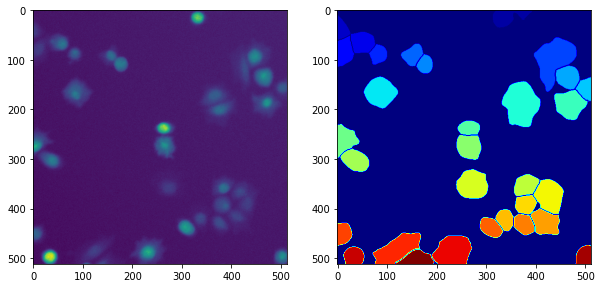

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(im[i, ..., 0])
ax[1].imshow(labeled_im[i, ..., 0], cmap='jet')
plt.show()

tile_image: model_input_shape =  (32, 32, 1) , stride_ratio =  0.5
untile_image: model_input_shape =  (32, 32, 1) , stride_ratio =  0.5
Avg diff =  -1.3593817996114403
Avg init =  515.0890858007701
Avg untiled =  516.4484676003816
Difference is:  -0.002632173169043664


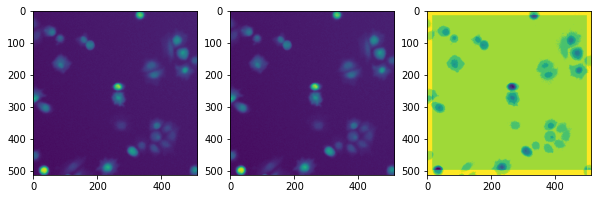

In [56]:
dtype='int32'
#dtype = 'uint16'
input_shape = (32, 32, 1)
stride_ratio = 0.5

difference_threshold = 0.1


initial_image = im.astype(dtype)

tiles, tiles_info = utils.tile_image(initial_image, model_input_shape=input_shape, stride_ratio=stride_ratio)

# version of untile image defined above
#untiled_image = _untile_image(tiles, tiles_info, model_input_shape=input_shape) 

#version of untile image defined in deepcell-toolbox - need to edit that and restart kernel to see changes
untiled_image = utils.untile_image(tiles, tiles_info, model_input_shape=input_shape, stride_ratio=stride_ratio) 

diff = initial_image - untiled_image

print('Avg diff = ', np.average(diff))
print('Avg init = ', np.average(initial_image))
print('Avg untiled = ', np.average(untiled_image))

print('Difference is: ', np.average(diff)/np.average(untiled_image))


fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(initial_image[i, ..., 0].astype('float32'))
ax[1].imshow(untiled_image[i, ..., 0].astype('float32'))
ax[2].imshow(diff[i, ..., 0].astype('float32'))
plt.show()

In [57]:
dtype='float32'

input_shape = (64, 64, 1)

shape = (4, 256, 256, 1)

#initial_image = (np.random.random(shape) * 100).astype(dtype)
initial_image = (np.zeros(shape)+5).astype(dtype)

tiles, tiles_info = utils.tile_image(initial_image, model_input_shape=input_shape, stride_ratio=0.75)

#untiled_image = untile_image_test(tiles, tiles_info, model_input_shape=input_shape)
untiled_image = utils.untile_image(tiles, tiles_info, model_input_shape=input_shape, stride_ratio=0.5)

diff = initial_image - untiled_image

print('Avg init = ', np.average(initial_image))
print('Avg untiled = ', np.average(untiled_image))

# rough estimate of relative difference between input & ouput
print('Difference is: ', np.average(diff)/np.average(untiled_image))

np.testing.assert_allclose(initial_image, untiled_image, 1e-3)


fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(initial_image[i, ..., 0])
ax[1].imshow(untiled_image[i, ..., 0])
ax[2].imshow(diff[i, ..., 0])
plt.show()

tile_image: model_input_shape =  (64, 64, 1) , stride_ratio =  0.75
untile_image: model_input_shape =  (64, 64, 1) , stride_ratio =  0.5
Avg diff =  2.185668
Avg init =  5.0
Avg untiled =  2.814332
Difference is:  0.7766205


AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatch: 92.1%
Max absolute difference: 4.684746
Max relative difference: 14.860228
 x: array([[[[5.],
         [5.],
         [5.],...
 y: array([[[[5.],
         [5.],
         [5.],...

In [49]:
from itertools import product

import numpy as np
from skimage.measure import label



def test_untile_image():
    shapes = [
        (1, 512, 512, 1),
        (4, 512, 512, 2),
        (4, 512, 512, 3),
    ]

    acceptable_difference_threshold = 0.1

    model_input_shapes = [(128, 128)]

    stride_ratios = [ 0.5 ] #, 0.66, 0.75, 0.8]      

    dtypes = ['int32', 'float32', 'uint16', 'float16']

    prod = product(shapes, model_input_shapes, stride_ratios, dtypes)

    for shape, input_shape, stride_ratio, dtype in prod:

        big_image = (np.random.random(shape) * 100).astype(dtype)
        tiles, tiles_info = utils.tile_image(big_image, model_input_shape=input_shape,
                                            stride_ratio=stride_ratio)

        #untiled_image = utils.untile_image(tiles, tiles_info, model_input_shape=input_shape,
        #                                  stride_ratio=stride_ratio)
        
        untiled_image = _untile_image(tiles, tiles_info, model_input_shape=input_shape,
                                      stride_fraction=stride_ratio)

        assert untiled_image.dtype == dtype
        assert untiled_image.shape == shape

        diff = big_image - untiled_image

        avg_diff = np.average(diff)
        avg_init = np.average(big_image)
        rel_diff = np.absolute(avg_diff / avg_init)

        #assert rel_diff < acceptable_difference_threshold

        print("relative difference is: ", rel_diff)
        np.testing.assert_allclose(big_image, untiled_image, 1e-1)
        
#    for const in range(0, 10)

#        shape = (1, 256, 256, 1)
#        model_input_shape = (64, 64)
#        stride_ratio = 0.5
#        big_image = 

    # test stride_fraction of 0
'''    with pytest.raises(ValueError):
        untiled_image = utils.untile_image(
            tiles=tiles, tiles_info=tiles_info,
            model_input_shape=input_shape, stride_fraction=0)

        # test stride_fraction of 1
    with pytest.raises(ValueError):
        untiled_image = utils.untile_image(
            tiles=tiles, tiles_info=tiles_info,
            model_input_shape=input_shape, stride_fraction=1)'''

'    with pytest.raises(ValueError):\n        untiled_image = utils.untile_image(\n            tiles=tiles, tiles_info=tiles_info,\n            model_input_shape=input_shape, stride_fraction=0)\n\n        # test stride_fraction of 1\n    with pytest.raises(ValueError):\n        untiled_image = utils.untile_image(\n            tiles=tiles, tiles_info=tiles_info,\n            model_input_shape=input_shape, stride_fraction=1)'

In [50]:
test_untile_image()

tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.00018328145
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.00018312114
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0
tile_image: model_input_shape =  (128, 128) , stride_ratio =  0.5
relative difference is:  0.0001831651
tile_image: model_inp